In [15]:
from pathlib import Path
import random, json
import numpy as np
import torch, os
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
from torchvision.transforms import functional as TF
from PIL import Image, ImageOps
import timm
from tqdm import tqdm
from typing import List, Tuple, Dict, Optional
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

Create Config metrics for easier variable changing later down the line

In [16]:
DATA_ROOT = Path("data_sanitized")   # data/infected, data/noninfected
MODEL_DIR = Path("models_ultrasound"); MODEL_DIR.mkdir(parents=True, exist_ok=True)

# switch to MobileNet (mobile-friendly)
BACKBONE = "mobilenetv3_large_100"

IMG_SIZE, BATCH_SIZE = 224, 12
NUM_EPOCHS, FREEZE_EPOCHS = 20, 5
LR_HEAD, LR_BACKBONE, WEIGHT_DECAY = 1e-3, 1e-4, 1e-5

# now we split into train/val/test from a single root
PATIENCE_ES, VAL_SPLIT, TEST_SPLIT, RANDOM_SEED = 6, 0.15, 0.15, 42

# limit to first 4000 images per class to speed up experiments
LIMIT_PER_CLASS = 4000

POS_LABEL_IDX, NUM_WORKERS = 0, 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = True

USE_DISK_CACHE = True
CACHE_DIR = Path("cache_ultrasound")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
PIN = (torch.cuda.is_available())
FORCE_REBUILD_CACHE = True

In [17]:
#for reproduction purposes set all variable random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed()
torch.backends.cudnn.benchmark = True

Data transformations, to further augment the data and be better prepared for actual traning and generalization towards messy irl data

In [18]:
#ok tldr, a lot of ultrasound images are very biased with their data, classes have massive disparities in non-medical related artifacts so we try to fix it

# ImageNet normalization (what MobileNet expects)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

IMG_SIZE = 224  # or whatever input size you used for the model (must match ONNX too)

class EnsureGray3:
    """Convert grayscale ultrasound images to 3 channels for pretrained backbones."""
    def __call__(self, img: Image.Image) -> Image.Image:
        g = img.convert("L")
        return Image.merge("RGB", (g, g, g))

# ---------------------- TRAIN TRANSFORMS ----------------------
train_tf = transforms.Compose([
    EnsureGray3(),                             # convert grayscale → RGB
    transforms.CenterCrop(int(IMG_SIZE * 0.92)),  # small crop to remove residual borders
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),    # small augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # gentle photometric aug
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------------------- VALIDATION / TEST TRANSFORMS ----------------------
val_tf = transforms.Compose([
    EnsureGray3(),
    transforms.CenterCrop(int(IMG_SIZE * 0.92)),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


Caching the data for faster load times

In [19]:
from functools import lru_cache

def _materialize_split(root_dir: Path, indices, tfm, dtype=torch.float32):
    """Load images for given indices, apply tfm, stack to a single tensor."""
    base = datasets.ImageFolder(str(root_dir), transform=None)
    xs, ys = [], []
    for i in indices:
        path, y = base.samples[i]
        img = Image.open(path).convert("RGB")
        x = tfm(img)                      # [3, IMG_SIZE, IMG_SIZE], float32
        xs.append(x.unsqueeze(0))
        ys.append(y)
    X = torch.cat(xs, dim=0).to(dtype)    # store fp16 to cut disk & RAM ~50%
    y = torch.tensor(ys, dtype=torch.long)
    return X, y

def build_and_save_cache(root_dir: Path, tr_idx_all, va_idx_all, te_idx_all, overwrite=False):
    paths = {
        "train_x": CACHE_DIR/"train_x.pt",
        "train_y": CACHE_DIR/"train_y.pt",
        "val_x":   CACHE_DIR/"val_x.pt",
        "val_y":   CACHE_DIR/"val_y.pt",
        "test_x":  CACHE_DIR/"test_x.pt",
        "test_y":  CACHE_DIR/"test_y.pt",
    }
    if (not overwrite) and all(p.exists() for p in paths.values()):
        print("[cache] Using existing cached tensors.")
        return paths

    print("[cache] Building cached tensors (first run only)…")
    X_tr, y_tr = _materialize_split(root_dir, tr_idx_all, train_tf)
    X_va, y_va = _materialize_split(root_dir, va_idx_all,  val_tf)
    X_te, y_te = _materialize_split(root_dir, te_idx_all,  val_tf)

    torch.save(X_tr.cpu(), paths["train_x"]); torch.save(y_tr.cpu(), paths["train_y"])
    torch.save(X_va.cpu(), paths["val_x"]);   torch.save(y_va.cpu(), paths["val_y"])
    torch.save(X_te.cpu(), paths["test_x"]);  torch.save(y_te.cpu(), paths["test_y"])
    print("[cache] Saved tensors to", CACHE_DIR.absolute())
    return paths

from torch.utils.data import TensorDataset
def make_cached_loaders(paths):
    Xtr = torch.load(paths["train_x"], map_location="cpu")
    ytr = torch.load(paths["train_y"], map_location="cpu")
    Xva = torch.load(paths["val_x"],   map_location="cpu")
    yva = torch.load(paths["val_y"],   map_location="cpu")
    Xte = torch.load(paths["test_x"],  map_location="cpu")
    yte = torch.load(paths["test_y"],  map_location="cpu")

    ds_tr = TensorDataset(Xtr, ytr)
    ds_va = TensorDataset(Xva, yva)
    ds_te = TensorDataset(Xte, yte)

    # Workers=0 is fine now (no PIL decode during training)
    train_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=PIN)
    val_loader   = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=PIN)
    test_loader  = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=PIN)
    return train_loader, val_loader, test_loader    


Create the data loaders 

In [20]:
def build_dataloaders(root_dir: Path):
    # 1) Scan dataset & compute hashes (group duplicates)
    base = datasets.ImageFolder(str(root_dir), transform=None)
    class_names = base.classes

    import hashlib
    def file_sha1(path):
        h = hashlib.sha1()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(1<<20), b""):
                h.update(chunk)
        return h.hexdigest()

    # Build groups: {class_id: {hash: [indices...]}}
    groups = {c: {} for c in range(len(class_names))}
    for idx, (path, y) in enumerate(base.samples):
        h = file_sha1(path)
        groups[y].setdefault(h, []).append(idx)

    # 2) Limit per class by GROUPS (not by images) to avoid splitting dupes across splits
    #    We’ll pick groups until we reach ~LIMIT_PER_CLASS images per class.
    rng = random.Random(RANDOM_SEED)
    per_class_group_keys = {}
    for c in range(len(class_names)):
        keys = list(groups[c].keys())
        rng.shuffle(keys)
        picked, total = [], 0
        for k in keys:
            sz = len(groups[c][k])
            if total + sz > LIMIT_PER_CLASS:
                # include if we have none yet (avoid empty) else stop
                if total == 0:
                    picked.append(k); total += sz
                break
            picked.append(k); total += sz
        per_class_group_keys[c] = picked

    # 3) Split by GROUPS (so duplicates stay together)
    def split_group_keys(keys, val_ratio, test_ratio):
        n = len(keys)
        n_val = int(n * val_ratio)
        n_test = int(n * test_ratio)
        n_train = n - n_val - n_test
        return keys[:n_train], keys[n_train:n_train+n_val], keys[n_train+n_val:]

    tr_idx_all, va_idx_all, te_idx_all = [], [], []
    for c in range(len(class_names)):
        keys = per_class_group_keys[c][:]
        rng.shuffle(keys)
        tr_g, va_g, te_g = split_group_keys(keys, VAL_SPLIT, TEST_SPLIT)
        # flatten group -> indices
        for k in tr_g: tr_idx_all.extend(groups[c][k])
        for k in va_g: va_idx_all.extend(groups[c][k])
        for k in te_g: te_idx_all.extend(groups[c][k])

    # 4) Class counts for weighting (same as before)
    tr_labels = [base.samples[i][1] for i in tr_idx_all]
    class_counts = {class_names[i]: tr_labels.count(i) for i in range(len(class_names))}

    # Split info for diagnostics
    split_info = {"train": tr_idx_all, "val": va_idx_all, "test": te_idx_all}

    # 5) Use your disk-cache fast path if enabled
    if USE_DISK_CACHE:
        paths = build_and_save_cache(root_dir, tr_idx_all, va_idx_all, te_idx_all, overwrite=False)
        train_loader, val_loader, test_loader = make_cached_loaders(paths)
        return train_loader, val_loader, test_loader, class_names, class_counts, split_info

    # 6) Fallback: classic ImageFolder subsets (no cache)
    ds_train = datasets.ImageFolder(str(root_dir), transform=train_tf)
    ds_val   = datasets.ImageFolder(str(root_dir), transform=val_tf)
    ds_test  = datasets.ImageFolder(str(root_dir), transform=val_tf)

    train_subset = Subset(ds_train, tr_idx_all)
    val_subset   = Subset(ds_val,   va_idx_all)
    test_subset  = Subset(ds_test,  te_idx_all)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=(DEVICE.type=='cuda'))
    val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=(DEVICE.type=='cuda'))
    test_loader  = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=(DEVICE.type=='cuda'))

    return train_loader, val_loader, test_loader, class_names, class_counts, split_info


# New call:
train_loader, val_loader, test_loader, class_names, class_counts, split_info = build_dataloaders(DATA_ROOT)
print("Classes:", class_names, "Train counts:", class_counts)
POS_LABEL_IDX = class_names.index('infected') if 'infected' in class_names else 1   


[cache] Using existing cached tensors.
Classes: ['infected', 'noninfected'] Train counts: {'infected': 2801, 'noninfected': 2827}
Classes: ['infected', 'noninfected'] Train counts: {'infected': 2801, 'noninfected': 2827}


In [21]:

# Map class indices -> names
idx2name = {i: n for i, n in enumerate(class_names)}
name2idx = {n: i for i, n in enumerate(class_names)}

# Choose your positive class by name, with a safe fallback
POS_NAME = 'infected' if 'infected' in name2idx else class_names[1]
POS_LABEL_IDX = name2idx[POS_NAME]

print("Classes:", class_names, "Train counts:", class_counts)
print(f"[Label mapping] idx->name: {idx2name}")
print(f"[Positive class] '{POS_NAME}' at index {POS_LABEL_IDX}")


Classes: ['infected', 'noninfected'] Train counts: {'infected': 2801, 'noninfected': 2827}
[Label mapping] idx->name: {0: 'infected', 1: 'noninfected'}
[Positive class] 'infected' at index 0


In [22]:
# --- DUPLICATE / LEAKAGE CHECKS ---
base = datasets.ImageFolder(str(DATA_ROOT), transform=None)

def overlap(a, b): return len(set(a) & set(b))
def names(idxs):   return set(Path(base.samples[i][0]).name for i in idxs)

tr = split_info["train"]; va = split_info["val"]; te = split_info["test"]

print("index overlap (must all be 0):")
print("  train ∩ val :", overlap(tr, va))
print("  train ∩ test:", overlap(tr, te))
print("  val   ∩ test:", overlap(va, te))

print("basename collisions (suspicious if large):")
print("  train↔val  :", len(names(tr) & names(va)))
print("  train↔test :", len(names(tr) & names(te)))
print("  val  ↔test :", len(names(va) & names(te)))


index overlap (must all be 0):
  train ∩ val : 0
  train ∩ test: 0
  val   ∩ test: 0
basename collisions (suspicious if large):
  train↔val  : 168
  train↔test : 152
  val  ↔test : 44


In [23]:
# --- Exact-duplicate (hash) collision check ---
import hashlib

base = datasets.ImageFolder(str(DATA_ROOT), transform=None)

def file_sha1(path):
    h = hashlib.sha1()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

def hashes(idxs):
    return {file_sha1(base.samples[i][0]) for i in idxs}

print("sha1 collisions (must be 0):")
print("  train↔val  :", len(hashes(split_info["train"]) & hashes(split_info["val"])))
print("  train↔test :", len(hashes(split_info["train"]) & hashes(split_info["test"])))
print("  val  ↔test :", len(hashes(split_info["val"]) & hashes(split_info["test"])))


sha1 collisions (must be 0):
  train↔val  : 0
  train↔val  : 0
  train↔test : 0
  train↔test : 0
  val  ↔test : 0
  val  ↔test : 0


The model we are using is the MobileNet Imageclassifer, as the name implies, it should work well on an app since it's mobile friendly

In [24]:
def create_model(name = BACKBONE, pretrained = True):
    return timm.create_model(name, pretrained = pretrained, num_classes = 1)


In [25]:
#since there is a minor class imbalance, we need to punish the model for miscalssifying infected sets
def pos_weight_from_counts(counts: Dict[str,int], pos_name: str):
    n_pos = max(1, counts[pos_name])
    n_neg = max(1, sum(counts.values()) - n_pos)
    return torch.tensor([n_neg / n_pos], dtype=torch.float32, device=DEVICE)


#define the func to train over one epoch (so we can call it in fit)
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    preds = []
    targs = []

    for imgs, y in loader:
        imgs, y = imgs.to(DEVICE),  y.float().unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        #create a context object to use both for forward and backward prop
        ctx = torch.cuda.amp.autocast if (USE_AMP and torch.cuda.is_available()) else torch.cpu.amp.autocast

        with ctx():
            logits = model(imgs)
            loss = criterion(logits, y)

        if scaler: 
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds.append(torch.sigmoid(logits).detach().cpu().numpy().ravel())
        targs.append(y.cpu().numpy().ravel())
 
    return total_loss/len(loader.dataset), roc_auc_score(np.concatenate(targs), np.concatenate(preds))

#disable torch gradient
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval(); total_loss=0; preds=[]; targs=[]
    for imgs,y in loader:
        imgs, y = imgs.to(DEVICE), y.float().unsqueeze(1).to(DEVICE)
        logits = model(imgs); loss = criterion(logits,y)
        total_loss += loss.item()*imgs.size(0)
        preds.append(torch.sigmoid(logits).cpu().numpy().ravel())
        targs.append(y.cpu().numpy().ravel())
    y_true, y_pred = np.concatenate(targs), np.concatenate(preds)
    return (total_loss/len(loader.dataset),
            roc_auc_score(y_true,y_pred),
            average_precision_score(y_true,y_pred),
            y_true, y_pred)

In [ ]:
from time import perf_counter

# Warm up CUDA context early (so it doesn't surprise you mid-epoch)
if torch.cuda.is_available():
    print("CUDA:", torch.cuda.get_device_name(0))
    _ = torch.randn(1, device="cuda"); torch.cuda.synchronize()
    print("CUDA warm-up done.")

# Time the first batch end-to-end
t0 = perf_counter()
xb, yb = next(iter(train_loader))
t1 = perf_counter(); print(f"[Probe] Load first batch: {t1 - t0:.3f}s")

xb = xb.to(DEVICE, non_blocking=True); yb = yb.float().unsqueeze(1).to(DEVICE, non_blocking=True)
if DEVICE.type == "cuda": torch.cuda.synchronize()
t2 = perf_counter(); print(f"[Probe] H2D transfer:     {t2 - t1:.3f}s")

model_probe = timm.create_model(BACKBONE, pretrained=False, num_classes=1).to(DEVICE).eval()
with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type=="cuda")):
    logits = model_probe(xb)
if DEVICE.type == "cuda": torch.cuda.synchronize()
t3 = perf_counter(); print(f"[Probe] First forward:    {t3 - t2:.3f}s")


CUDA: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA warm-up done.
[Probe] Load first batch: 0.091s
[Probe] H2D transfer:     0.003s


C:\Users\Jomar\AppData\Local\Temp\ipykernel_17172\1232058422.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type=="cuda")):


[Probe] First forward:    2.951s


In [ ]:
def fit(train_loader, val_loader, test_loader, class_counts):
    model = create_model(BACKBONE).to(DEVICE)

    # freeze backbone first
    if FREEZE_EPOCHS > 0:
        for n,p in model.named_parameters(): p.requires_grad=False
        for n,p in model.named_parameters():
            if any(k in n for k in ("head","fc","classifier","pre_logits")): p.requires_grad=True

    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                                  lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss(
    pos_weight = pos_weight_from_counts(class_counts, POS_NAME)
)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=3)
    scaler = torch.cuda.amp.GradScaler(enabled = USE_AMP and torch.cuda.is_available())

    best_auc, patience = -np.inf, 0
    for epoch in range(1, NUM_EPOCHS+1):
        print(f"Starting epoch {epoch}…", flush=True)
        if epoch == FREEZE_EPOCHS+1: # unfreeze
            for p in model.parameters(): p.requires_grad=True
            optimizer = torch.optim.AdamW(model.parameters(),
                                          lr=LR_BACKBONE, weight_decay=WEIGHT_DECAY)
        tr_loss,tr_auc = train_one_epoch(model,train_loader,optimizer,criterion,scaler)
        va_loss,va_auc,va_ap,_,_ = evaluate(model,val_loader,criterion)
        scheduler.step(va_auc)
        print(f"Epoch {epoch} | Train AUC {tr_auc:.3f} | Val AUC {va_auc:.3f} AP {va_ap:.3f}")
        if va_auc>best_auc: best_auc=va_auc; patience=0; torch.save(model.state_dict(), MODEL_DIR/"best.pth")
        else: patience+=1; 
        if patience>=PATIENCE_ES: print("Early stopping."); break
    return model

model = fit(train_loader,val_loader,test_loader,class_counts)


Starting epoch 1…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_17172\2899382285.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled = USE_AMP and torch.cuda.is_available())
C:\Users\Jomar\AppData\Local\Temp\ipykernel_17172\1554103780.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Epoch 1 | Train AUC 0.935 | Val AUC 0.986 AP 0.985
Starting epoch 2…


C:\Users\Jomar\AppData\Local\Temp\ipykernel_17172\1554103780.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


In [ ]:
#only run if fit was not run


model = create_model(BACKBONE).to(DEVICE)

[Label mapping] idx->name: {0: 'infected', 1: 'noninfected'}
[Positive class] 'infected' at index 0
Test AUC (pos='infected') = 0.997
Test AP  (pos='infected') = 0.997
Test AUC (pos='infected') = 0.997
Test AP  (pos='infected') = 0.997


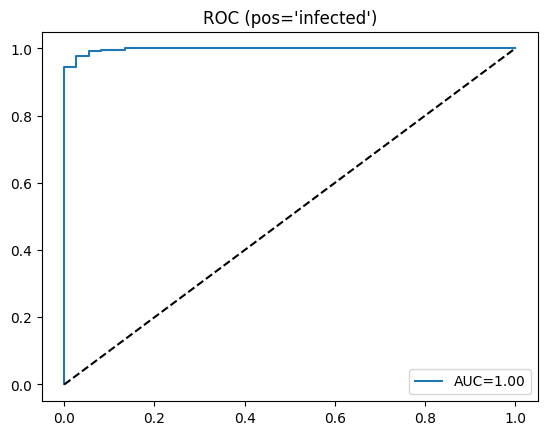

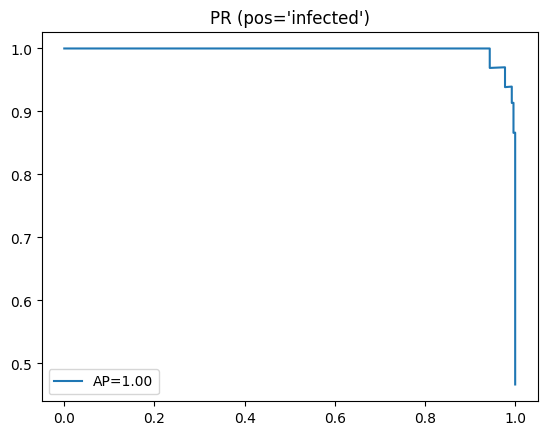


[Threshold = 0.5] Confusion matrix:
 [[296   8]
 [ 12 254]]
              precision    recall  f1-score   support

not_infected       0.96      0.97      0.97       304
    infected       0.97      0.95      0.96       266

    accuracy                           0.96       570
   macro avg       0.97      0.96      0.96       570
weighted avg       0.96      0.96      0.96       570

[Threshold = 0.192 (Youden J)] Confusion matrix:
 [[296   8]
 [  6 260]]
              precision    recall  f1-score   support

not_infected       0.98      0.97      0.98       304
    infected       0.97      0.98      0.97       266

    accuracy                           0.98       570
   macro avg       0.98      0.98      0.98       570
weighted avg       0.98      0.98      0.98       570

[Threshold = 0.192 (max F1)] Confusion matrix:
 [[296   8]
 [  6 260]]
              precision    recall  f1-score   support

not_infected       0.98      0.97      0.98       304
    infected       0.97      0.9

In [ ]:
import matplotlib.pyplot as plt



# ---- Positive class mapping (robust) ----
idx2name = {i: n for i, n in enumerate(class_names)}
name2idx = {n: i for i, n in enumerate(class_names)}

POS_NAME = 'infected' if 'infected' in name2idx else class_names[1]
POS_LABEL_IDX = name2idx[POS_NAME]
print(f"[Label mapping] idx->name: {idx2name}")
print(f"[Positive class] '{POS_NAME}' at index {POS_LABEL_IDX}")

# ---- Loss weighting consistent with POS_NAME ----
def pos_weight_from_counts(counts, pos_name):
    n_pos = max(1, counts[pos_name])
    n_neg = max(1, sum(counts.values()) - n_pos)
    return torch.tensor([n_neg / n_pos], dtype=torch.float32, device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_from_counts(class_counts, POS_NAME))

# ---- Load best model & evaluate to get raw probs for class index 1 ----
model.load_state_dict(torch.load(MODEL_DIR / "best.pth", map_location=DEVICE))
test_loss, _, _, y_true_raw, y_prob_class1 = evaluate(model, test_loader, criterion)

# ---- Re-express everything w.r.t. your POS_NAME ----
# y_true_pos: 1 if sample belongs to POS_NAME, else 0
y_true_pos = (y_true_raw == POS_LABEL_IDX).astype(int)

# y_prob_pos: probability that sample is POS_NAME
# (evaluate() returns prob for class index 1; flip probs if POS is not index 1)
y_prob_pos = y_prob_class1 if POS_LABEL_IDX == 1 else (1.0 - y_prob_class1)

# ---- Scalar metrics ----
auc = roc_auc_score(y_true_pos, y_prob_pos)
ap  = average_precision_score(y_true_pos, y_prob_pos)
print(f"Test AUC (pos='{POS_NAME}') = {auc:.3f}")
print(f"Test AP  (pos='{POS_NAME}') = {ap:.3f}")

# ---- Curves ----
fpr, tpr, thr_roc = roc_curve(y_true_pos, y_prob_pos)
prec, rec, thr_pr = precision_recall_curve(y_true_pos, y_prob_pos)

plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.title(f"ROC (pos='{POS_NAME}')"); plt.legend(); plt.show()

plt.plot(rec, prec, label=f"AP={ap:.2f}")
plt.title(f"PR (pos='{POS_NAME}')"); plt.legend(); plt.show()

# ---- Thresholding & reports ----
# 0) Default threshold at 0.5
pred_05 = (y_prob_pos >= 0.5).astype(int)
cm_05 = confusion_matrix(y_true_pos, pred_05)
print("\n[Threshold = 0.5] Confusion matrix:\n", cm_05)
print(classification_report(
    y_true_pos, pred_05,
    target_names=[f"not_{POS_NAME}", POS_NAME]
))

# 1) Youden's J (maximizes TPR - FPR) from ROC
if len(thr_roc) > 0:
    j = tpr - fpr
    j_idx = int(np.argmax(j))
    thr_j = thr_roc[j_idx]
    pred_j = (y_prob_pos >= thr_j).astype(int)
    cm_j = confusion_matrix(y_true_pos, pred_j)
    print(f"[Threshold = {thr_j:.3f} (Youden J)] Confusion matrix:\n", cm_j)
    print(classification_report(
        y_true_pos, pred_j,
        target_names=[f"not_{POS_NAME}", POS_NAME]
    ))

# 2) Best F1 from PR curve (skip last point which has no threshold)
if len(prec) > 1 and len(thr_pr) > 0:
    f1s = 2*prec*rec/(prec+rec+1e-9)
    best_f1_idx = int(np.nanargmax(f1s[:-1]))  # align with thr_pr
    thr_f1 = float(thr_pr[best_f1_idx])
    pred_f1 = (y_prob_pos >= thr_f1).astype(int)
    cm_f1 = confusion_matrix(y_true_pos, pred_f1)
    print(f"[Threshold = {thr_f1:.3f} (max F1)] Confusion matrix:\n", cm_f1)
    print(classification_report(
        y_true_pos, pred_f1,
        target_names=[f"not_{POS_NAME}", POS_NAME]
    ))



In [ ]:
# ---- Imbalance-aware metrics + paper-ready table (IMAGE) ----
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score, precision_recall_fscore_support,
    confusion_matrix, balanced_accuracy_score, matthews_corrcoef,
    accuracy_score
)

IMG_POS_NAME = POS_NAME  # keep naming consistent with your code

def _eval_image_split_with_imbalance(y_true_pos, y_prob_pos, split_name):
    # Thresholded predictions at 0.5 (same policy as tabular)
    pred = (y_prob_pos >= 0.5).astype(int)

    # Class distribution
    n = len(y_true_pos)
    pos = int(np.sum(y_true_pos))
    neg = n - pos
    base_rate = pos / max(1, n)
    pred_pos = int(np.sum(pred))
    pred_pos_rate = pred_pos / max(1, n)

    # Threshold-independent metrics
    auc = roc_auc_score(y_true_pos, y_prob_pos)
    ap  = average_precision_score(y_true_pos, y_prob_pos)  # PR-AUC

    # Threshold-dependent @0.5
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_pos, pred, average="binary", zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true_pos, pred).ravel()
    acc  = accuracy_score(y_true_pos, pred)
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    bacc = balanced_accuracy_score(y_true_pos, pred)
    mcc  = matthews_corrcoef(y_true_pos, pred) if len(np.unique(y_true_pos)) == 2 else np.nan

    # Console summary (same style as tabular)
    print(f"\n[{split_name}] class distribution: "
          f"pos={pos} ({base_rate:.1%}), neg={neg} ({1-base_rate:.1%}), n={n}")
    print(f"[{split_name}] AUC={auc:.3f} | PR-AUC(AP)={ap:.3f} | "
          f"Acc@0.5={acc:.3f} | Prec@0.5={prec:.3f} | Rec@0.5={rec:.3f} | "
          f"F1@0.5={f1:.3f} | Spec@0.5={spec:.3f} | BalAcc@0.5={bacc:.3f} | MCC@0.5={mcc:.3f}")
    print(f"[{split_name}] Predicted positive rate @0.5: {pred_pos}/{n} ({pred_pos_rate:.1%})")
    print(f"[{split_name}] Confusion matrix @0.5 (rows=true, cols=pred):\n"
          f"[[TN FP]\n [FN TP]]\n{np.array([[tn, fp], [fn, tp]])}")

    return {
        "n": n, "pos": pos, "neg": neg,
        "base_rate": float(base_rate),
        "pred_pos_rate@0.5": float(pred_pos_rate),
        "AUC": float(auc), "AP": float(ap),
        "ACC@0.5": float(acc), "Precision@0.5": float(prec),
        "Recall@0.5": float(rec), "F1@0.5": float(f1),
        "Specificity@0.5": float(spec), "BalancedAcc@0.5": float(bacc),
        "MCC@0.5": float(mcc),
        "cm@0.5": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
    }

# Evaluate (test split here; add val split if you have one)
img_test_summary = _eval_image_split_with_imbalance(y_true_pos, y_prob_pos, "Test")

# ---- Paper-friendly table (same columns/order as tabular) ----
summary_img_df = pd.DataFrame([{
    "Split": "Test",
    "Positives": f"{img_test_summary['pos']} / {img_test_summary['n']} ({100*img_test_summary['base_rate']:.1f}%)",
    "AUC": f"{img_test_summary['AUC']:.3f}",
    "PR-AUC": f"{img_test_summary['AP']:.3f}",
    "Accuracy": f"{img_test_summary['ACC@0.5']:.3f}",
    "Precision": f"{img_test_summary['Precision@0.5']:.3f}",
    "Recall": f"{img_test_summary['Recall@0.5']:.3f}",
    "F1-Score": f"{img_test_summary['F1@0.5']:.3f}",
    "Specificity": f"{img_test_summary['Specificity@0.5']:.3f}",
    "BalAcc": f"{img_test_summary['BalancedAcc@0.5']:.3f}",
    "MCC": f"{img_test_summary['MCC@0.5']:.3f}",
}])

print("\n=== Model Evaluation Summary (Image Classifier) ===")
display(summary_img_df.style.set_table_styles(
    [{"selector": "th", "props": [("text-align", "center"), ("font-weight", "bold")]}]
).set_properties(**{"text-align": "center"}))

# Optional exports for paper
# summary_img_df.to_csv("image_model_results.csv", index=False)
# print(summary_img_df.to_latex(index=False, float_format="%.3f"))



[Test] class distribution: pos=266 (46.7%), neg=304 (53.3%), n=570
[Test] AUC=0.997 | PR-AUC(AP)=0.997 | Acc@0.5=0.965 | Prec@0.5=0.969 | Rec@0.5=0.955 | F1@0.5=0.962 | Spec@0.5=0.974 | BalAcc@0.5=0.964 | MCC@0.5=0.930
[Test] Predicted positive rate @0.5: 262/570 (46.0%)
[Test] Confusion matrix @0.5 (rows=true, cols=pred):
[[TN FP]
 [FN TP]]
[[296   8]
 [ 12 254]]

=== Model Evaluation Summary (Image Classifier) ===


,Split,Positives,AUC,PR-AUC,Accuracy,Precision,Recall,F1-Score,Specificity,BalAcc,MCC
0,Test,266 / 570 (46.7%),0.997,0.997,0.965,0.969,0.955,0.962,0.974,0.964,0.930


[Grad-CAM] Using target layer: blocks.6.0.conv with spatial size (7, 7)
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000
[CAM] min=0.0000, max=1.0000


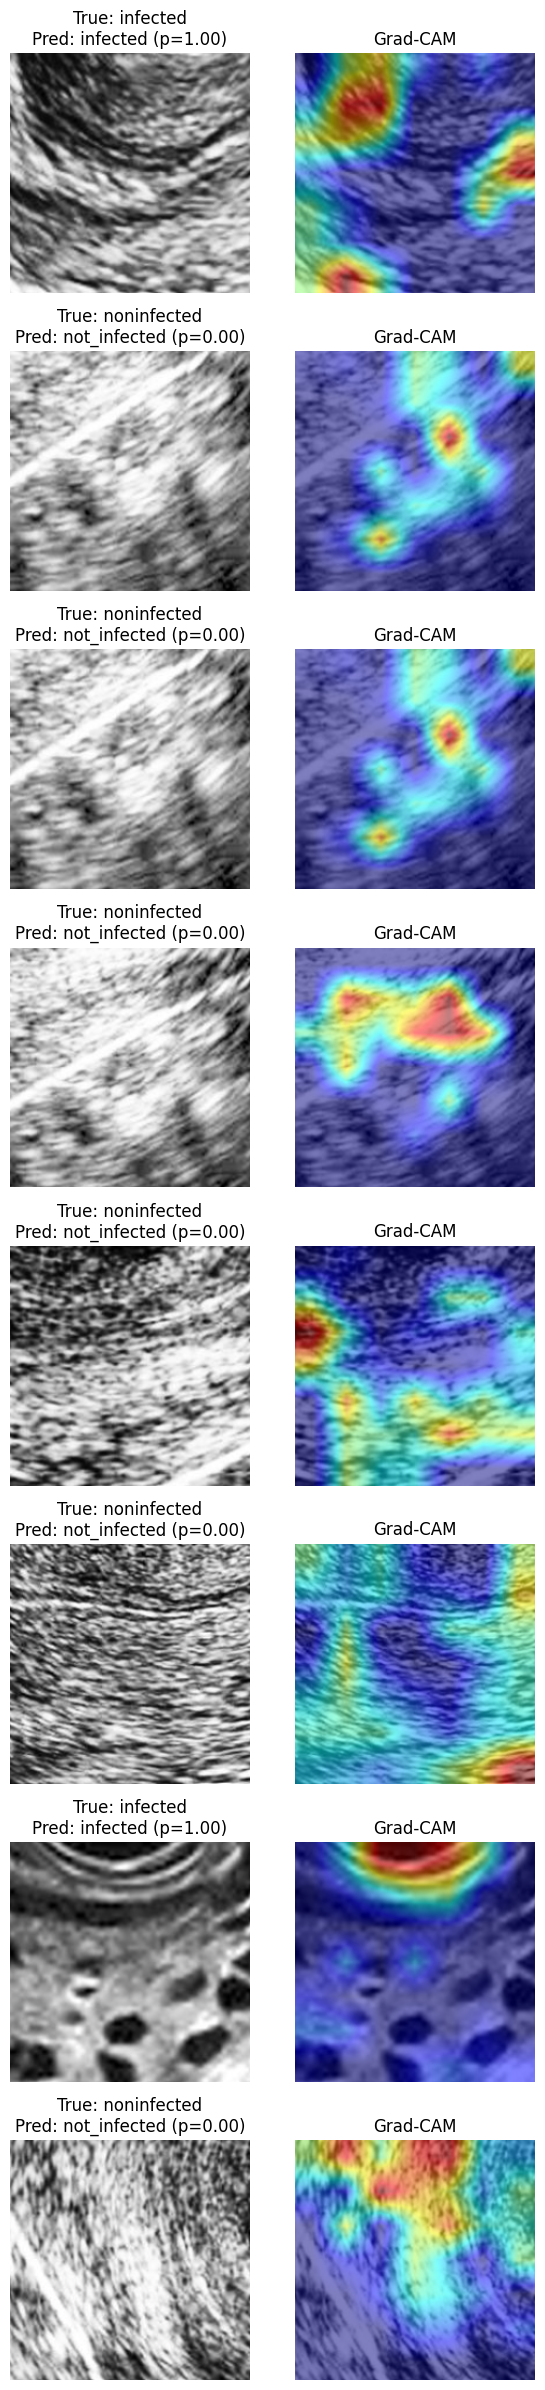

In [ ]:
# ---- Grad-CAM (robust version) ----
import torch, numpy as np, matplotlib.pyplot as plt, random
import torch.nn as nn
import torchvision.transforms.functional as TF
from collections import OrderedDict
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 0) Ensure eval + grads enabled (no no_grad here)
model.eval()
for p in model.parameters():
    p.requires_grad_(True)

# 1) Probe the model to list all Conv2d feature maps with spatial size > 1x1
def list_spatial_convs(m: nn.Module, sample: torch.Tensor, device: torch.device):
    hooks, feats = [], OrderedDict()
    def hook_fn(name):
        def _fn(_, __, out):
            o = out[0] if isinstance(out, (tuple, list)) else out
            if isinstance(o, torch.Tensor):
                feats[name] = tuple(o.shape[-2:])  # (H, W)
        return _fn

    for name, layer in m.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    with torch.enable_grad():
        _ = m(sample.to(device))

    for h in hooks: h.remove()
    spatial = [(n, hw) for n, hw in feats.items() if hw[0] > 1 and hw[1] > 1]
    return spatial

# 2) Get a small normalized sample from your TEST loader (TensorDataset)
xb, yb = next(iter(test_loader))
sample = xb[:1]                                # [1,3,H,W]

spatial_convs = list_spatial_convs(model, sample, DEVICE)
assert len(spatial_convs) > 0, "No spatial Conv2d feature maps found."

# Pick the LAST spatial conv (closest to the head but still HxW>1)
target_name = spatial_convs[-1][0]
target_layer = dict(model.named_modules())[target_name]
print(f"[Grad-CAM] Using target layer: {target_name} with spatial size {spatial_convs[-1][1]}")

# 3) Denormalizer for visualization
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
def denorm_to_numpy(img_tensor: torch.Tensor) -> np.ndarray:
    x = img_tensor.detach().cpu().numpy()
    x = (x * IMAGENET_STD[:,None,None] + IMAGENET_MEAN[:,None,None]).clip(0,1)
    return np.transpose(x, (1,2,0)).astype(np.float32)

# 4) Build CAM object (try PlusPlus first; fallback to plain if near-zero)
cam_pp = GradCAMPlusPlus(model=model, target_layers=[target_layer])
cam_plain = GradCAM(model=model, target_layers=[target_layer])

def compute_cam(img_tensor: torch.Tensor):
    inp = img_tensor.unsqueeze(0).to(DEVICE)        # [1,3,H,W]
    targets = [ClassifierOutputTarget(0)]           # single-logit binary head
    # Grad-CAM++
    grayscale = cam_pp(input_tensor=inp, targets=targets)[0]
    m, M = float(grayscale.min()), float(grayscale.max())
    # If almost flat, try plain Grad-CAM (often higher contrast)
    if M - m < 1e-6:
        grayscale = cam_plain(input_tensor=inp, targets=targets)[0]
        m, M = float(grayscale.min()), float(grayscale.max())
    print(f"[CAM] min={m:.4f}, max={M:.4f}")
    # Normalize just in case
    if M > m:
        grayscale = (grayscale - m) / (M - m + 1e-8)
    base = denorm_to_numpy(img_tensor)              # HWC float [0,1]
    overlay = show_cam_on_image(base, grayscale, use_rgb=True)
    return base, overlay

# 5) Visualize a few random test samples
rng = random.Random()
num_to_show = 8
indices = rng.sample(range(len(test_loader.dataset)), num_to_show)

fig, axes = plt.subplots(num_to_show, 2, figsize=(6, 3*num_to_show))
if num_to_show == 1: axes = np.array([axes])

for r, idx in enumerate(indices):
    img_tensor, label_idx = test_loader.dataset[idx]   # from cached TensorDataset
    base_img, overlay = compute_cam(img_tensor)

    prob = float(y_prob_pos[idx])                      # from your eval() block
    true_name = class_names[label_idx]
    pred_name = POS_NAME if prob >= 0.5 else f"not_{POS_NAME}"

    axes[r,0].imshow(base_img)
    axes[r,0].set_title(f"True: {true_name}\nPred: {pred_name} (p={prob:.2f})")
    axes[r,0].axis("off")

    axes[r,1].imshow(overlay)
    axes[r,1].set_title("Grad-CAM")
    axes[r,1].axis("off")

plt.tight_layout()
plt.show()



# Export PyTorch model to ONNX
Here we'll export the trained PyTorch model to ONNX format for deployment and reuse.

In [ ]:
import torch.onnx

# Create ONNX export directory
ONNX_DIR = Path("onnx_models")
ONNX_DIR.mkdir(parents=True, exist_ok=True)

# Set the model to evaluation mode
model.eval()

# Create a dummy input tensor (batch_size=1, channels=3, height=IMG_SIZE, width=IMG_SIZE)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

# Export the model to ONNX
onnx_path = ONNX_DIR / "pcos_image_model.onnx"
torch.onnx.export(
    model,                      # model being run
    dummy_input,               # model input (or a tuple for multiple inputs)
    onnx_path,                 # where to save the model
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=11,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=['input'],     # the model's input names
    output_names=['output'],   # the model's output names
    dynamic_axes={
        'input': {0: 'batch_size'},  # variable length axes
        'output': {0: 'batch_size'}
    }
)

print(f"Image model exported to ONNX format: {onnx_path}")

# Optional: Test the ONNX model
import onnxruntime as rt
import numpy as np

# Create inference session
sess = rt.InferenceSession(str(onnx_path))
input_name = sess.get_inputs()[0].name

# Run inference on a sample
sample_input = xb[:1].to('cpu').numpy()  # Use a real image from the test set
pred_onx = sess.run(None, {input_name: sample_input})[0]
pred_torch = torch.sigmoid(model(xb[:1].to(DEVICE))).detach().cpu().numpy()

print("\nONNX Model Test:")
print(f"ONNX prediction: {pred_onx[0][0]}")
print(f"PyTorch prediction: {pred_torch[0][0]}")

# Optional: Verify the model structure
import onnx

# Load and check the model structure
onnx_model = onnx.load(str(onnx_path))
print("\nONNX model check complete:", onnx.checker.check_model(onnx_model))

NameError: name 'X' is not defined